# Introduction

This project seeks to solve the problem of identifying pathological images as cancerous or non-cancerous. Better classification tools could help doctors detect cancer earlier and save patients' lives. 

The data for this competition is a version of the PatchCamelyon (PCam) benchmark dataset that does not contain duplicates. I obtained the dataset from the Kaggle competition page[3]. The data was provided to Kaggle by Bas Veeling[1], with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak[2].

The data consists of 96x96 color images extracted from histopathologic scans of lymph node sections. Each image is labelled to reflect the presence of metastatic tissue (cancer). There are 220,025 images in the training dataset

In [2]:
# Important Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# EDA and Data Cleaning
from PIL import Image

# Model Building and Training
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC

# Exploratory Data Analysis

To learn more about the dataset I will display a few examples of images of lymph node sections. I will also compare the relative frequency of cancerous and non-cancerous images. 

Each image can be represented by a 96x96x3 matrix of numerical values representing the pixels of the image and values for red, blue, and green. Therefore our dataset has 220,025 observations each with 27648 numerical features.

Image shape: (96, 96, 3)


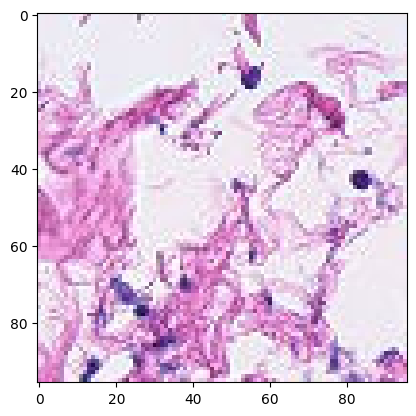

In [4]:
# Function to load images
def train_img_path(id_str):
    return os.path.join(r'train', f'{id_str}.tif')

# Load an example training image
example_img_path = train_img_path('0000d563d5cfafc4e68acb7c9829258a298d9b6a')
example_img = Image.open(example_img_path)
example_array = np.array(example_img)

print(f'Image shape: {example_array.shape}')
plt.imshow(example_img)
plt.show()


In [5]:
train_labels_df = pd.read_csv('train_labels.csv')

# add column of file paths, id corresponds to file name
train_labels_df['filename'] = train_labels_df['id'].apply(train_img_path)

# convert label to string
train_labels_df['label'] = train_labels_df['label'].astype(str)
print(train_labels_df['filename'].iloc[0])

try:
    img = Image.open(train_labels_df['filename'].iloc[0])
    img.show()  # This will display the image if it opens successfully
except Exception as e:
    print(f"Error opening image: {e}")

train\f38a6374c348f90b587e046aac6079959adf3835.tif


In [5]:
train_labels_df.shape

(220025, 3)

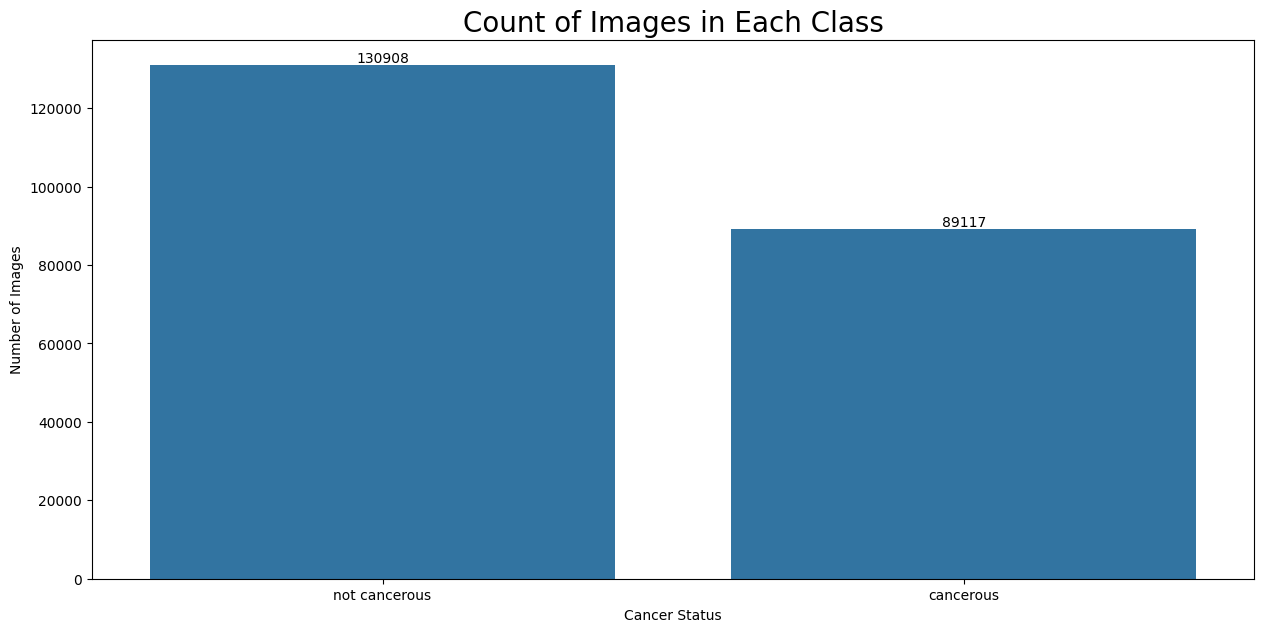

In [6]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_labels_df , x=train_labels_df['label'])

plt.xlabel('Cancer Status')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0,1], labels=['not cancerous', 'cancerous'])
plt.title('Count of Images in Each Class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

There is a discrepancy between the number of cancerous and non-cancerous images in the dataset. Since there are more images labeled as non-cancerous the model could become biased towards this label. Balancing the classes could remedy this issue. The imbalance also means metrics like accuracy will not properly reflect the quality of the predictions. The Kaggle competition uses ROC-AUC as its metric to determine the leaderboard which is less influenced by imbalanced classes.

In [7]:
# Load the first 100 images
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(100):
    img_path = train_labels_df['filename'][i]
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

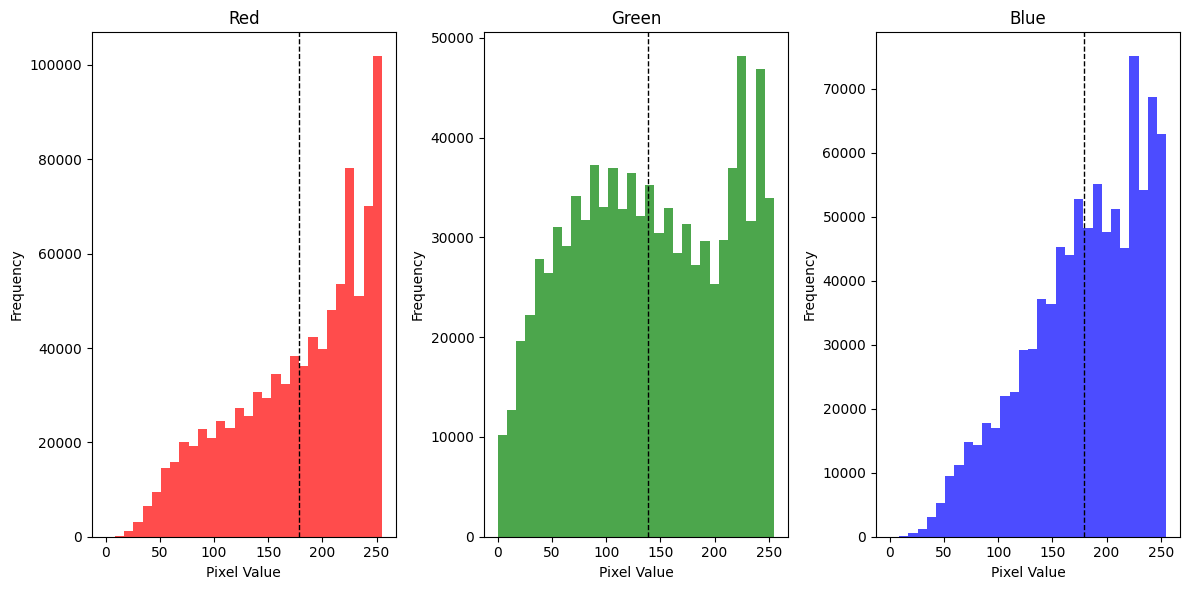

In [8]:
# Calculate the mean for each 96x96 observation across the first dimension (observations)
mean_values = np.mean(sample_data, axis=0)  # Shape will be (96, 96, 3)

# Now, calculate the mean across the spatial dimensions (height and width) for each channel
mean_channel_values = np.mean(mean_values, axis=(0, 1))  # Shape will be (3,)

# Create histograms for each channel
colors = ['r', 'g', 'b']  # Assuming channels are in RGB order
channel_labels = ['Red', 'Green', 'Blue']

plt.figure(figsize=(12, 6))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(sample_data[..., i].flatten(), bins=30, color=colors[i], alpha=0.7)
    plt.axvline(mean_channel_values[i], color='k', linestyle='dashed', linewidth=1)
    plt.title(channel_labels[i])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As can be seen from the pixel value histograms red and blue have much higher average pixel values than green. This can be seen in the example images which are predominantly purple. All of the pixel value histograms have some values near 255 likely corresponding to black parts of the image.

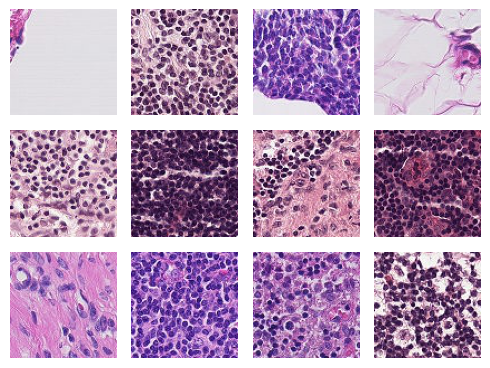

In [9]:
# Get 12 random non-cancerous images
sample_non_cancerous = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = 4

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][sample_non_cancerous[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

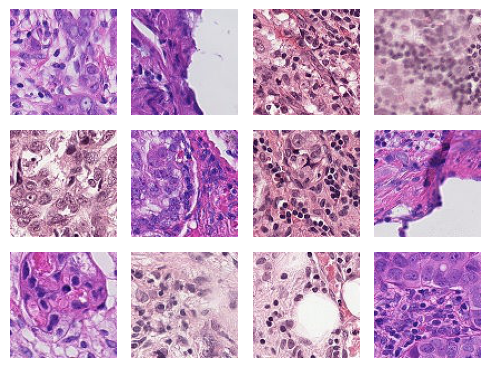

In [10]:
# Get 12 random cancerous images
sample_cancerous = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = 4

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][sample_cancerous[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

# Data Cleaning and Preprocessing
This data came from a Kaggle competition so most of the data cleaning was already completed. There are no missing values so nothing needs to be imputed. All of the data is in image form with numerical values for the individual pixels in each color. This means there is no need to one-hot encode categorical data. Keras has an ImageDataGenerator class which I will use to preprocess the data. To use the class_mode binary I needed to convert my labels to strings. I will normalize the images to [0,1] range using the rescale parameter and set aside 20% of the training data for validation during the fitting process.

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = True,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = True,
    seed = 10
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [11]:
# total number of steps to yield from generator before declaring epoch finished
train_steps_per_epoch = int(np.ceil(176020 // 32))
val_steps_per_epoch = int(np.ceil(44005 // 32))

# Model Building and Training

For my model I took inspiration from the VGGnet model which performs well at classifying images. This model consists of a separate feature extractor section and classifier section. The feature extractor section has convolution layers and max pool layers. Convolution layers are able to detect features in the dataset with much fewer parameters than a fully connected layer. The fewer parameters leads to computational efficiency and better classifying performance. The max pool layers increase the field of reference for the pixels in later layers which captures more complex interactions between features. 

Max pooling also decreases the size of the feature map. Because of this decrease in input size I was able to increase the number of filters for the later stages of my model.

VGG16 uses three fully connected layers as the classifier section. Due to computational resource constraints on my machine I will use one fully connected layer instead. I used a sigmoid activation function for the output layer to match the problem type of binary classification.

VGG16 is available for import from tensorflow. While it would be possible to use transfer learning to use the first few layers from the pre-trained VGG16, I will build my own model to set my own parameters. I will follow the structure of the A configuration for VGG16, the simplest configuration.

In [12]:
_input = Input((96,96,3))

# Stage 1
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
pool1  = MaxPooling2D((2, 2))(conv1)

# Stage 2
conv2  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
pool2  = MaxPooling2D((2, 2))(conv2)

# Stage 3
conv3  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv4  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool3  = MaxPooling2D((2, 2))(conv4)

# Stage 4
conv5  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv6  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv5)
pool4  = MaxPooling2D((2, 2))(conv6)

# Stage 5
conv7 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv8 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv7)
pool5  = MaxPooling2D((2, 2))(conv8)

# Classifier stage
flat   = Flatten()(pool5)
output = Dense(1, activation="sigmoid")(flat)

model  = Model(inputs=_input, outputs=output)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,225,089 (35.19 MB)

 Trainable params: 9,225,089 (35.19 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
model.compile(optimizer = Nadam(learning_rate = 0.0001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC()])

In [14]:
tf.keras.config.disable_traceback_filtering()
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    validation_data = validation_generator,
    validation_steps = val_steps_per_epoch,
    epochs = 10
)

Epoch 1/10


c:\Users\order\repos\cnn-cancer-detection\myvenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 673/5500 ━━━━━━━━━━━━━━━━━━━━ 1:25:44 1s/step - accuracy: 0.7221 - auc_1: 0.7799 - loss: 0.5361

## Citations

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

[3] https://www.kaggle.com/c/histopathologic-cancer-detection/overview

[4] https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

[5] https://www.kaggle.com/code/mohammedhamzamoawad/histopathologic-cancer-detection